## 10_2. Mapping single-cell profile onto spatial profile

<div style="text-align: left;">
    <p style="text-align: left;">Updated Time: 2025-04-09</p>
</div>

# Mapping single-cell profile onto spatial profile

Tangram is a method for mapping single-cell (or single-nucleus) gene expression data onto spatial gene expression data. Tangram takes as input a single-cell dataset and a spatial dataset, collected from the same anatomical region/tissue type. Via integration, Tangram creates new spatial data by aligning the scRNAseq profiles in space. This allows to project every annotation in the scRNAseq (e.g. cell types, program usage) on space.

The most common application of Tangram is to resolve cell types in space. Another usage is to correct gene expression from spatial data: as scRNA-seq data are less prone to dropout than (e.g.) Visium or Slide-seq, the “new” spatial data generated by Tangram resolve many more genes. As a result, we can visualize program usage in space, which can be used for ligand-receptor pair discovery or, more generally, cell-cell communication mechanisms. If cell segmentation is available, Tangram can be also used for deconvolution of spatial data. If your single cell are multimodal, Tangram can be used to spatially resolve other modalities, such as chromatin accessibility.

Biancalani, T., Scalia, G., Buffoni, L. et al. Deep learning and alignment of spatially resolved single-cell transcriptomes with Tangram. Nat Methods 18, 1352–1362 (2021). https://doi.org/10.1038/s41592-021-01264-7

##### Load libraries

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import infercnvpy as cnv
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import omicverse as ov
ov.plot_set()

import warnings
warnings.simplefilter("ignore")

2025-04-09 22:35:06.961196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 22:35:07.738940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.8/lib64:
2025-04-09 22:35:07.739070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.8/lib64:
2025-04-09 22:35:07.739079: W tensorflow/compiler/tf2tensorrt/utils/py_uti


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/
Dependency error: (pydeseq2 0.5.0 (/home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages), Requirement.parse('pydeseq2<=0.4.0,>=0.3'))


##### Set working directory for analysis

In [2]:
cwd = '/media/bio/Disk/Research Data/EBV/omicverse'
os.chdir(cwd)
updated_dir = os.getcwd()
print("Updated working directory: ", updated_dir)

from pathlib import Path
saving_dir = Path('Results/10.NPC_ST_Analysis')
saving_dir.mkdir(parents=True, exist_ok=True)

Updated working directory:  /media/bio/Disk/Research Data/EBV/omicverse


### Prepared scRNA-seq

<Axes: title={'center': 'Celltype'}, xlabel='X_umap1', ylabel='X_umap2'>

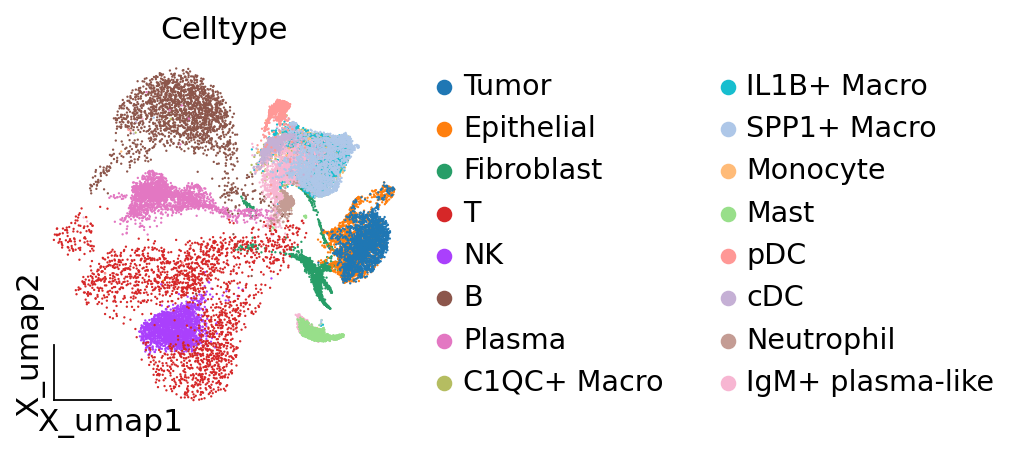

In [3]:
adata_sc=ov.read("Processed Data/adata_ref_sample_2000_cells.h5ad")
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ov.utils.embedding(
    adata_sc,
    basis="X_umap",
    color=['Celltype'],
    title='Celltype',
    frameon='small',
    #ncols=1,
    wspace=0.65,
    #palette=ov.utils.pyomic_palette()[11:],
    show=False,
    ax=ax
)

For data quality control and preprocessing, we can easily use omicverse's own preprocessing functions to do so

In [4]:
print("RAW",adata_sc.X.max())
adata_sc=ov.pp.preprocess(adata_sc,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
adata_sc.raw = adata_sc
adata_sc = adata_sc[:, adata_sc.var.highly_variable_features]
print("Normalize",adata_sc.X.max())

RAW 42872
Begin robust gene identification
After filtration, 24785/24785 genes are kept.     Among 24785 genes, 24455 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['SPP1', 'TIMP1', 'HBB', 'FTH1', 'MALAT1', 'FTL', 'IGKC', 'IGKV4-1', 'IGKV1-5', 'IGKV1-6', 'IGKV1-8', 'IGKV1-9', 'IGKV3-11', 'IGKV1-12', 'IGKV3-15', 'IGKV1-16', 'IGKV1-17', 'IGKV3-20', 'IGKV6-21', 'IGKV2-24', 'IGKV1-27', 'IGKV2-28', 'IGKV2-29', 'IGKV2-30', 'IGKV1-39', 'IGKV2D-40', 'IGKV1D-39', 'IGKV1D-33', 'IGKV2D-30', 'IGKV2D-29', 'IGKV2D-28', 'IGKV3D-20', 'IGKV1D-17', 'IGKV1D-16', 'IGKV3D-15', 'IGKV1D-13', 'IGKV3D-11', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'IGHV6-1', 'IGHV1-2', 'IGHV1-3', 'IGHV4-4', 'IGHV7-4-1', 'IGHV2-5', 'IGHV3-7', 'IGHV5-10-1', 'IGHV3-11', 'IGHV3-13', 'IGHV3-15', 'IGHV1-18', 'IGHV3-21', '

### Prepared stRNA-seq

First let’s read spatial Visium data from 10X Space Ranger output. Here we use lymph node data generated by 10X and presented in [Kleshchevnikov et al (section 4, Fig 4)](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1). This dataset can be conveniently downloaded and imported using scanpy. See [this tutorial](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_short_demo.html) for a more extensive and practical example of data loading (multiple visium samples).

In [5]:
adata = sc.read_h5ad("Processed Data/GSE206245_NPC_ST_Cluster.h5ad")
adata

AnnData object with n_obs × n_vars = 21078 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'library_id', 'batch', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'scNiche'
    uns: 'batch_colors', 'hvg', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'log1p', 'neighbors', 'scNiche_colors', 'spatial', 'umap'
    obsm: 'STAGATE', 'STAligner', 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [6]:
print(np.min(adata.X), np.max(adata.X))

0.0 19642.0


In [7]:
for i in adata.obs['sample_id'].cat.categories:
  number = len(adata.obs[adata.obs['sample_id']==i])
  print('the number of category {} is {}'.format(i,number))

the number of category NPC_ST05 is 1994
the number of category NPC_ST06 is 2572
the number of category NPC_ST07 is 1934
the number of category NPC_ST08 is 1089
the number of category NPC_ST09 is 1703
the number of category NPC_ST10 is 1179
the number of category NPC_ST11 is 1112
the number of category NPC_ST12 is 3651
the number of category NPC_ST16 is 1540
the number of category NPC_ST17 is 1941
the number of category NPC_ST18 is 1298
the number of category NPC_ST19 is 1065


We used the same pre-processing steps as for scRNA-seq

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    We introduced the spatial special svg calculation module prost in omicverse versions greater than `1.6.0` to replace scanpy's HVGs, if you want to use scanpy's HVGs you can set mode=`scanpy` in `ov.space.svg` or use the following code.
  </p>
</div>

```python
#adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
#adata.raw = adata
#adata = adata[:, adata.var.highly_variable_features]
```

In [8]:
# sc.pp.calculate_qc_metrics(adata, inplace=True)
# adata = adata[:,adata.var['total_counts']>100]
adata.X = adata.X.toarray()
adata.raw = adata
adata=ov.space.svg(adata,mode='prost',n_svgs=3000,target_sum=1e4,platform="visium",)
adata = adata[:, adata.var.space_variable_features]
adata_sp=adata.copy()
adata_sp


Filtering genes ...

Calculating image index 1D:

Normalize each geneing...

Gaussian filtering...


100%|██████████| 11102/11102 [02:15<00:00, 82.00it/s]



Binary segmentation for each gene:


100%|██████████| 11102/11102 [02:19<00:00, 79.34it/s]



Spliting subregions for each gene:


100%|██████████| 11102/11102 [28:37<00:00,  6.46it/s]



Computing PROST Index for each gene:


100%|██████████| 11102/11102 [00:19<00:00, 559.45it/s]



PROST Index calculation completed !!
PI calculation is done!


  0%|          | 0/11102 [00:00<?, ?it/s]2025-04-09 23:09:45.574127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:45.574270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:45.574285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missin


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/


2025-04-09 23:09:48.416142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:48.416398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:48.416422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

2025-04-09 23:09:49.253161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:49.253396: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:49.253416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

2025-04-09 23:09:50.152211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.152384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.152403: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/


2025-04-09 23:09:50.356635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.356924: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.356949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials:

2025-04-09 23:09:50.561921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.562101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.562119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/


2025-04-09 23:09:50.776737: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.776931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.776946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

2025-04-09 23:09:50.990899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.991073: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:50.991090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/


2025-04-09 23:09:51.407843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:51.408041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:51.408056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

2025-04-09 23:09:51.636920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:51.637116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:51.637134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

2025-04-09 23:09:51.845285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:51.845544: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:51.845566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

2025-04-09 23:09:52.450390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:52.450657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-12.8/lib64:
2025-04-09 23:09:52.450679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/            

100%|██████████| 11102/11102 [16:33<00:00, 11.18it/s] 


Spatial autocorrelation test is done!
normalizing counts per cell
    finished (0:00:00)
normalization and log1p are done!


AnnData object with n_obs × n_vars = 21078 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'library_id', 'batch', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'scNiche', 'image_idx_1d'
    var: 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'space_variable_features', 'highly_variable'
    uns: 'batch_colors', 'hvg', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'log1p', 'neighbors', 'scNiche_colors', 'spatial', 'umap', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index'
    obsm: 'STAGATE', 'STAligner', 'X_pca', 'X_umap', 'spatial'
    layers:

## Tangram model

Tangram is a Python package, written in PyTorch and based on scanpy, for mapping single-cell (or single-nucleus) gene expression data onto spatial gene expression data. The single-cell dataset and the spatial dataset should be collected from the same anatomical region/tissue type, ideally from a biological replicate, and need to share a set of genes. 

We can use `omicverse.space.Tangram` to apply the Tangram model.

In [9]:
tg=ov.space.Tangram(adata_sc,adata_sp,clusters='Celltype')

tangram have been install version: 1.0.4
ranking genes
    finished: added to `.uns['Celltype_rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
...Calculate The Number of Markers: 939


INFO:root:274 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:527 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


...Model prepared successfully


The function maps iteratively as specified by num_epochs. We typically interrupt mapping after the score plateaus. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data on the training genes. 
- The default mapping mode is mode=`cells`, which is recommended to run on a GPU. 
- Alternatively, one can specify mode=`clusters` which averages the single cells beloning to the same cluster (pass annotations via cluster_label). This is faster, and is our chioce when scRNAseq and spatial data come from different specimens. 
- If you wish to run Tangram with a GPU, set device=`cuda:0` otherwise use the set device=`cpu`. 
- density_prior specifies the cell density within each spatial voxel. Use uniform if the spatial voxels are at single cell resolution (ie MERFISH). The default value, rna_count_based, assumes that cell density is proportional to the number of RNA molecules

In [10]:
tg.train(mode="cells",num_epochs=500,device="cpu")

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 274 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.707, KL reg: 0.045
Score: 0.825, KL reg: 0.002
Score: 0.855, KL reg: 0.001
Score: 0.865, KL reg: 0.001
Score: 0.869, KL reg: 0.001


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


...Model train successfully


We can use `tg.cell2location()` to get the cell location in spatial spots.

In [11]:
adata_plot=tg.cell2location()
adata_plot.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'library_id', 'batch', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4',
       'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5',
       'scNiche', 'image_idx_1d', 'uniform_density', 'rna_count_based_density',
       'NK', 'Fibroblast', 'Neutrophil', 'B', 'IgM+ plasma-like', 'Epithelial',
       'Mast', 'Tumor', 'Plasma', 'C1QC+ Macro', 'SPP1+ Macro', 'Monocyte',
       'pDC', 'IL1B+ Macro', 'cDC', 'T'],
      dtype='object')

In [12]:
adata_plot.obs.head()

,in_tissue,array_row,array_col,sample_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,Mast,Tumor,Plasma,C1QC+ Macro,SPP1+ Macro,Monocyte,pDC,IL1B+ Macro,cDC,T
AAACAAGTATCTCCCA-1_NPC_ST05,1,50,102,NPC_ST05,7051,8.861067,24458.0,10.104754,24.061657,27.794587,...,0.152736,0.186492,0.121126,0.407942,0.397296,0.227205,0.160516,0.023027,0.283748,0.407330
AAACACCAATAACTGC-1_NPC_ST05,1,59,19,NPC_ST05,6840,8.830689,25173.0,10.133567,28.633854,32.709649,...,0.002337,0.095439,0.073945,0.078903,0.072934,0.291537,0.072167,0.364098,0.202935,0.094017
AAACATTTCCCGGATT-1_NPC_ST05,1,61,97,NPC_ST05,6878,8.836229,23995.0,10.085642,26.334653,30.072932,...,0.121241,0.235449,0.221011,0.322479,0.177819,0.171617,0.152591,0.163551,0.147021,0.312427
AAACCCGAACGAAATC-1_NPC_ST05,1,45,115,NPC_ST05,2917,7.978654,6462.0,8.773849,36.737852,40.900650,...,0.000888,0.001042,0.002245,0.002819,0.146575,0.247218,0.216437,0.149839,0.001100,0.104673
AAACCGGGTAGGTACC-1_NPC_ST05,1,42,28,NPC_ST05,6334,8.753845,18742.0,9.838576,18.621278,22.921780,...,0.001827,0.244971,0.329808,0.360554,0.412028,0.303337,0.097617,0.047827,0.374087,0.003535


#### Save Spatial AnnData Object with Tangram Mapping

In [16]:
adata_plot

AnnData object with n_obs × n_vars = 21078 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'library_id', 'batch', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'scNiche', 'image_idx_1d', 'uniform_density', 'rna_count_based_density', 'NK', 'Fibroblast', 'Neutrophil', 'B', 'IgM+ plasma-like', 'Epithelial', 'Mast', 'Tumor', 'Plasma', 'C1QC+ Macro', 'SPP1+ Macro', 'Monocyte', 'pDC', 'IL1B+ Macro', 'cDC', 'T'
    var: 'n_cells', 'SEP', 'SIG', 'PI', 'Moran_I', 'Geary_C', 'p_norm', 'p_rand', 'fdr_norm', 'fdr_rand', 'space_variable_features', 'highly_variable', 'sparsity'
    uns: 'batch_colors', 'hvg', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'lei

In [17]:
adata_plot = adata_plot.raw.to_adata()
adata_plot

AnnData object with n_obs × n_vars = 21078 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'library_id', 'batch', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'scNiche', 'image_idx_1d', 'uniform_density', 'rna_count_based_density', 'NK', 'Fibroblast', 'Neutrophil', 'B', 'IgM+ plasma-like', 'Epithelial', 'Mast', 'Tumor', 'Plasma', 'C1QC+ Macro', 'SPP1+ Macro', 'Monocyte', 'pDC', 'IL1B+ Macro', 'cDC', 'T'
    uns: 'batch_colors', 'hvg', 'leiden_0_1', 'leiden_0_2', 'leiden_0_4', 'leiden_0_6', 'leiden_0_8', 'leiden_1_0', 'leiden_1_2', 'leiden_1_5', 'log1p', 'neighbors', 'scNiche_colors', 'spatial', 'umap', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index', '

In [18]:
print(adata_plot.X.shape)
print(np.min(adata_plot.X), np.max(adata_plot.X))

(21078, 17943)
0.0 19642.0


In [ ]:
adata_plot.write('Processed Data/GSE206245_NPC_ST_Cluster_Tangram.h5ad',compression='gzip')
adata_plot.obsm['tangram_ct_pred'].to_csv("/media/bio/Disk/Research Data/EBV/omicverse/Processed Data/tangram_ct_pred.csv")
adata_plot.obs[['sample_id', 'scNiche']].to_csv("/media/bio/Disk/Research Data/EBV/omicverse/Processed Data/GSE206245_NPC_ST_scNiche.csv")


**<span style="font-size:16px;">Session information：</span>**

In [20]:
import sys
import platform
import pkg_resources

# Get Python version information
python_version = sys.version
# Get operating system information
os_info = platform.platform()
# Get system architecture information
architecture = platform.architecture()[0]
# Get CPU information
cpu_info = platform.processor()
# Print Session information
print("Python version:", python_version)
print("Operating system:", os_info)
print("System architecture:", architecture)
print("CPU info:", cpu_info)

# Print imported packages and their versions
print("\nImported packages and their versions:")
for package in pkg_resources.working_set:
    print(package.key, package.version)

Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
Operating system: Linux-6.8.0-57-generic-x86_64-with-glibc2.35
System architecture: 64bit
CPU info: x86_64

Imported packages and their versions:
geneclust 1.0.0
squidpy 1.6.5
spagcn 1.2.7
leidenalg 0.10.2
igraph 0.11.8
hdbscan 0.8.40
loguru 0.7.3
zarr 2.18.4
xarray 2025.3.0
validators 0.34.0
tifffile 2025.3.13
spatialdata 0.3.0
cython 3.0.12
datetime 5.5
deprecated 1.2.18
markdown 3.7
markupsafe 2.1.5
pims 0.7
pot 0.9.5
pubchempy 1.0.4
pycomplexheatmap 1.8.1
pygsp 0.5.1
pyscipopt 5.3.0
pysocks 1.7.1
pywavelets 1.4.1
pyyaml 6.0.2
pyomo 6.8.2
send2trash 1.8.3
xlsxwriter 3.2.2
absl-py 2.1.0
ace-tools 0.0
adjusttext 1.3.0
aiobotocore 2.20.0
aiohappyeyeballs 2.4.6
aiohttp 3.11.12
aioitertools 0.12.0
aiosignal 1.3.2
anndata 0.11.3
annotated-types 0.7.0
annoy 1.17.3
anyio 4.8.0
appdirs 1.4.4
argcomplete 1.12.0
argon2-cffi 23.1.0
argon2-cffi-bindings 21.2.0
array-api-compat 1.10.0
arrow 1.3.0
arviz 